In [1]:
import meva
from meva.lib.spin import get_pretrained_hmr
import mmcv 
import torch
from meva.utils import image_utils
import utils
from utils import imshownp
from skimage.transform import resize
import numpy as np
import data
from utils import makedirs_ifno
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
from meva.utils import kp_utils
from matplotlib.pyplot import cm
import scipy

/home/tormod/Documents/APEC/meva/utils/transformations.py:1927: UserWarning: No module named 'meva.utils._transformations'
  warnings.warn(str(err))


# Run SPIN

In [76]:
from importlib import reload
reload(data)

<module 'data' from '/home/tormod/Documents/APEC/data.py'>

In [81]:
out_folder = '/home/tormod/ucph-erda-home/hmr_features'
c = data.ClimbingDataset('all', 
                         feat_folder=None, #out_folder,
                         seq_len=1)

In [82]:
d = c.get(0)

In [3]:
hmr = get_pretrained_hmr()

====> Loading pre trained: data/meva_data/spin_model_checkpoint.pth.tar


In [4]:
hmr.eval()
imgs = d['norm_imgs']
imgs = imgs[:1]
imgs = imgs.float().to('cuda')
feat, out = hmr(imgs, return_features=True)

In [ ]:
res = np.load(f'{out_folder}/{data.stripped_names[0]}.npy', allow_pickle=True)
out = res

In [15]:
out[0].keys()

dict_keys(['theta', 'verts', 'kp_2d', 'kp_3d', 'features'])

In [16]:
d.keys()

dict_keys(['raw_imgs', 'norm_imgs', 'features', 'raw_kp_2d', 'kp_2d', 'vid_idx', 'frames', 'bboxes', 'trans', 'inv_trans'])

In [ ]:
img = d['raw_imgs'][0]
norm_img = d['norm_imgs'][0]
imshownp(img)
kp_2d = out[0]['kp_2d'][0]
kp_2d = image_utils.normalize_2d_kp(kp_2d, inv=True)
#kp_3d = out[0]['kp_3d'].cpu().detach().numpy()[0]
kp_2d = image_utils.trans_points2d(kp_2d, d['inv_trans'])
plt.scatter(kp_2d[:,0], kp_2d[:,1])

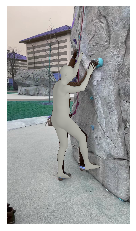

In [33]:
import mesh
reload(mesh)
verts = out[0]['verts'][0]
theta = out[0]['theta'][0]
bboxes = d['bboxes']
pred_cam = theta[:3]
pred_cam[0] *= 1.2
imshownp(mesh.render_pred_mesh(img, bboxes, verts, pred_cam))

# Render results

In [70]:
from meva.utils.renderer import Renderer
from meva.utils.demo_utils import convert_crop_cam_to_orig_img
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
def render_vids(cd, res, out_folder, vid_idx):
    vid = cd.vids[vid_idx]
    vid_name = data.stripped_names[vid_idx]
    cd.load_labels(vid_name)
    bboxes = cd.bboxes[vid_name]
    orig_width, orig_height = vid.resolution
    renderer = Renderer(resolution=(orig_width, orig_height), orig_img=True)
    for frame, r in tqdm(enumerate(res), total=(len(res))):
        img = vid[frame]
        verts = r['verts'][0]
        pred_cam = r['theta'][:, :3].copy()
        pred_cam[:, 0] *= 1.2
        bbox = bboxes[np.newaxis,frame]
        orig_cam = convert_crop_cam_to_orig_img(
            pred_cam, bbox, orig_width, orig_height)[0]
        mesh_img = renderer.render(img, verts, orig_cam)
        
        black_img = renderer.render(np.zeros_like(img), verts, orig_cam)  
        
        out_img = np.concatenate([black_img, mesh_img], axis=1)
        mmcv.imwrite(out_img, f'{out_folder}/{vid_name}/{frame:06d}.png')

    mmcv.frames2video(f'{out_folder}/{vid_name}', f'{out_folder}/{vid_name}.mp4',
                      filename_tmpl='{:06d}.png')

In [83]:
in_folder = '/home/tormod/ucph-erda-home/hmr_results'
out_folder = '/media/tormod/Den Lille/Thesis/hmr_results'
vid_idx = 0
vid_name = data.stripped_names[vid_idx]
res = np.load(f'{in_folder}/{vid_name}.npy', allow_pickle=True)

In [85]:
vid_folder = '/media/tormod/Den Lille/Thesis/videos'
cd = data.ClimbingDataset('all', video_folder=vid_folder)

In [86]:
render_vids(cd, res, out_folder, vid_idx)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6829/6829, 27.7 task/s, elapsed: 247s, ETA:     0s


# Eval Results

In [70]:
in_folder = '/home/tormod/ucph-erda-home/hmr_results'
def eval_res(split):
    cd = data.ClimbingDataset(split, preload_all=True)
    current_vid_name = ''
    res = []
    scores = []
    for seq_info in tqdm(cd):
        inv_trans = seq_info['inv_trans']
        vid_idx = seq_info['vid_idx']
        vid_name = data.stripped_names[vid_idx]
        if vid_name != current_vid_name:
            res = np.load(f'{in_folder}/{vid_name}.npy', allow_pickle=True)
            current_vid_name = vid_name
        scales = seq_info['bboxes'][:,-1]
        frames = seq_info['frames']
        pred_seq = np.concatenate([r['kp_2d'].copy() for r in res[frames[0]:frames[-1]+1]])
        gt_seq = seq_info['kp_2d'].numpy()
        oks_score = utils.oks(pred_seq, gt_seq, scales, inv_trans)
        scores.append(oks_score)
    scores = np.stack(scores)
    scores = scores.reshape(-1, scores.shape[-1])
    # delete values for eye joints
    scores = np.delete(scores, 1, 1)
    scores = np.delete(scores, 1, 1)
    return scores

In [79]:
oks_testval = eval_res('testval')

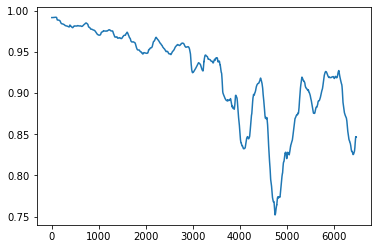

In [85]:
conv_N = 3*90
smooth_oks_testval = scipy.ndimage.convolve(oks_testval, np.ones((conv_N, 1))/conv_N, mode='mirror')
plt.plot(smooth_oks_testval.mean(axis=1))

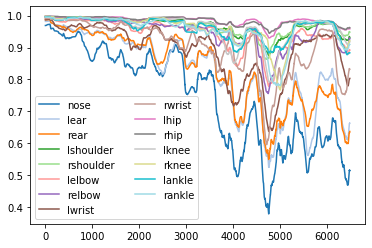

In [86]:
colors = cm.tab20(np.linspace(0,1,15))

coco_joint_names = kp_utils.get_coco_joint_names()
coco_joint_names = coco_joint_names[:1] + coco_joint_names[3:]

conv_N = 3*90

for j in range(oks_testval.shape[1]):
    j_oks = oks_testval[:,j].copy()
    j_oks = scipy.ndimage.convolve(j_oks, np.ones(conv_N)/conv_N, mode='mirror')
    plt.plot(j_oks, label=coco_joint_names[j], color=colors[j])
plt.legend(loc='lower left', ncol=2)